In [1]:
import os
import numpy as np
import pandas as pd
import itertools as it
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, Delaunay, distance_matrix

# pymatgen tools
from pymatgen import MPRester
from pymatgen.io.xyz import XYZ
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.transformations.standard_transformations import RotationTransformation
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint

In [2]:
mpr = MPRester("RyfhcbEkpUtKPxC6")

# Functions: MPQuery, Construct supercell, rotate/tilt/crop/shift function, write xyz and atomic coord files

In [9]:
def MPQuery(formula, space_grp=''):
    
    mpr = MPRester("RyfhcbEkpUtKPxC6")
    query = mpr.query(criteria={"pretty_formula": formula}, properties=["structure","icsd_ids","spacegroup"])
    if space_grp:
        query = [query[i] for i in range(len(query)) if SpacegroupAnalyzer(query[i]['structure']).get_space_group_number() == space_grp]
    selected = query[np.argmin([query[i]['structure'].lattice.volume for i in range(len(query))])]
    pymatgen_structure = SpacegroupAnalyzer(selected["structure"]).get_conventional_standard_structure()
    
    return pymatgen_structure


def remove(string): 
    return string.replace(" ", "")

# Structure selection based on structure prototype and similarity

In [4]:
ssf = SiteStatsFingerprint(
        CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0),
        stats=('mean', 'std_dev', 'minimum', 'maximum'))

In [5]:
prototype = pd.read_csv('prototype_aflowlib_filtered.csv')
struc_proto = np.load('struc_proto.npy')

# Dask process

In [4]:
from dask.distributed import Client, progress
#from dask_mpi import initialize

In [5]:
client = Client()

In [6]:
import pandas as pd
import dask.dataframe as ddf

matid = pd.read_excel('matid_prototype.xlsx')
matid

,mat_id,type,sim_index,type_group,Include_flag,Final_prototype,Final_prototype_spcgrp,Final
0,mp-1,W,2.14994e-16,229,1,W,229,W_229
1,mp-10,H3S,1.75542e-16,229,1,H3S,229,H3S_229
2,mp-100,W,1.35974e-16,229,1,W,229,W_229
3,mp-10018,Cu,1.24577e-17,225,1,Cu,225,Cu_225
4,mp-10021,TiSi2,0.73108,70,1,TiSi2,70,TiSi2_70
...,...,...,...,...,...,...,...,...
121291,mp-1195392,BaSO4,1.60482,62,0,Other,0,Other_0
121292,mp-1195556,BaSi4O9,1.10846,188,0,Other,0,Other_0
121293,mp-1195590,Mg2SiO4,1.16234,62,0,Other,0,Other_0
121294,mp-1195797,Na5Fe3F14,1.21848,94,0,Other,0,Other_0


In [7]:
matid['composition'] = ''
matid['avg_atomic_num']= ''

In [8]:
matid_dask = ddf.from_pandas(matid, npartitions=1000)
matid_dask

,mat_id,type,sim_index,type_group,Include_flag,Final_prototype,Final_prototype_spcgrp,Final,composition,avg_atomic_num
npartitions=995,,,,,,,,,,
0,object,object,object,object,int64,object,int64,object,object,object
122,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
121268,...,...,...,...,...,...,...,...,...,...
121295,...,...,...,...,...,...,...,...,...,...


In [11]:
'''
def mapFunc1(x):
    try:
        struc = mpr.get_structure_by_material_id(x)
        mat_feature = np.array(ssf.featurize(struc))
        print(struc.formula)
    except:
        mat_feature = 'not a struc'
    #print(proto,spc_grp,sim_index)
    return mat_feature
'''

def mapFunc2(x):
    try:
        struc = mpr.get_structure_by_material_id(x)
        composition = remove(str(struc.composition))
        print(composition)
    except:
        composition = 'not a struc'
        print('not getting mat_feature')
    #print(proto,spc_grp,sim_index)
    return composition

def mapFunc3(x):
    try:
        struc = mpr.get_structure_by_material_id(x)
        atomic_num = np.average(struc.atomic_numbers)
    except:
        atomic_num = 'not a struc'
        print('not getting mat_feature')
    #print(proto,spc_grp,sim_index)
    return atomic_num

'''
def mapFunc4(mat_feature):
    try:
        #print(np.array(mat_feature))
        prtype = prototype['Prototype'].iloc[np.argmin(np.linalg.norm(np.array(mat_feature)-struc_proto,axis=1))]
    except:
        prtype = 'not a struc'
        print('not getting mat_feature')
    #print(proto,spc_grp,sim_index)
    return prtype

def mapFunc5(mat_feature):
    try:
        typ_grp = prototype['Space Group Number'].iloc[np.argmin(np.linalg.norm(np.array(mat_feature)-struc_proto,axis=1))]
    except:
        typ_grp = 'not a struc'
        print('not getting mat_feature')
    #print(proto,spc_grp,sim_index)
    return typ_grp

def mapFunc6(mat_feature):
    try:
        sim_index = np.min(np.linalg.norm(np.array(mat_feature)-struc_proto,axis=1))
    except:
        sim_index = 'not a struc'
        print('not getting mat_feature')
    #print(proto,spc_grp,sim_index)
    return sim_index
'''

def simple_map(df):
    df['composition'] = df['mat_id'].map(lambda x: mapFunc2(x))
    df['avg_atomic_num'] = df['mat_id'].map(lambda x: mapFunc3(x))
    return df

In [12]:
import timeit
    
start = timeit.default_timer()

matid_dask=matid_dask.map_partitions(simple_map).compute()

stop = timeit.default_timer()

print('Time: ', stop - start)  

not getting mat_feature
not getting mat_feature
not getting mat_feature
not getting mat_feature
Time:  1643.6536014112644


In [13]:
matid_dask

,mat_id,type,sim_index,type_group,Include_flag,Final_prototype,Final_prototype_spcgrp,Final,composition,avg_atomic_num
0,mp-1,W,2.14994e-16,229,1,W,229,W_229,Cs1,55.000000
1,mp-10,H3S,1.75542e-16,229,1,H3S,229,H3S_229,As1,33.000000
2,mp-100,W,1.35974e-16,229,1,W,229,W_229,Hf1,72.000000
3,mp-10018,Cu,1.24577e-17,225,1,Cu,225,Cu_225,Ac1,89.000000
4,mp-10021,TiSi2,0.73108,70,1,TiSi2,70,TiSi2_70,Ga2,31.000000
...,...,...,...,...,...,...,...,...,...,...
121291,mp-1195392,BaSO4,1.60482,62,0,Other,0,Other_0,Na20Er4H24W4O40,12.304348
121292,mp-1195556,BaSi4O9,1.10846,188,0,Other,0,Other_0,K10Y4Si8O26F2,13.680000
121293,mp-1195590,Mg2SiO4,1.16234,62,0,Other,0,Other_0,Na12Mn4S8O32F8,10.750000
121294,mp-1195797,Na5Fe3F14,1.21848,94,0,Other,0,Other_0,Hg4Sb14H4Xe6F118,16.602740


In [14]:
matid_dask.to_csv('matid_prototype.csv')

In [4]:
import pandas as pd

matid = pd.read_csv('../data/matid_prototype.csv')
matid

,Unnamed: 0,mat_id,type,sim_index,type_group,Include_flag,Final_prototype,Final_prototype_spcgrp,Final,composition,avg_atomic_num
0,0,mp-1,W,2.14993764247462e-16,229,1,W,229,W_229,Cs1,55.000000
1,1,mp-10,H3S,1.75541673428835e-16,229,1,H3S,229,H3S_229,As1,33.000000
2,2,mp-100,W,1.35973995551051e-16,229,1,W,229,W_229,Hf1,72.000000
3,3,mp-10018,Cu,1.24576957645282e-17,225,1,Cu,225,Cu_225,Ac1,89.000000
4,4,mp-10021,TiSi2,0.731080403801493,70,1,TiSi2,70,TiSi2_70,Ga2,31.000000
...,...,...,...,...,...,...,...,...,...,...,...
121291,121291,mp-1195392,BaSO4,1.60482209084893,62,0,Other,0,Other_0,Na20Er4H24W4O40,12.304348
121292,121292,mp-1195556,BaSi4O9,1.10845697978034,188,0,Other,0,Other_0,K10Y4Si8O26F2,13.680000
121293,121293,mp-1195590,Mg2SiO4,1.1623351852796,62,0,Other,0,Other_0,Na12Mn4S8O32F8,10.750000
121294,121294,mp-1195797,Na5Fe3F14,1.21847821498246,94,0,Other,0,Other_0,Hg4Sb14H4Xe6F118,16.602740


In [154]:
proto = matid['Final'].unique()

In [155]:
proto

array(['W_229', 'H3S_229', 'Cu_225', 'TiSi2_70', 'BN_186', 'Ga_64',
       'Other_0', 'Be2SiO4_148', 'BeO_136', 'Mg_194', 'InNi2_194',
       'CO_198', 'Ni3Sn_194', 'Cu3Au_221', 'C_139', 'Li_220', 'TiCu3_59',
       'BN_42', 'Sm_166', 'C_166', 'In_139', 'C_10', 'GaSb_119', 'Si_139',
       'C_227', 'ZrAl3_139', 'CdPt3_65', 'CuS_194', 'Hg4Pt_229',
       'FeAs_62', 'La_194', 'Cu2Te_191', 'C_205', 'CdSb_61', 'NiAs_194',
       'MgNi2_194', 'Ni3S2_155', 'Sc_178', 'MnAl6_63', 'ZrSi2_63',
       'Si_206', 'SiC_160', 'P_13', 'Pu_12', 'SiO2_194', 'CsCl_221',
       'BN_194', 'As_166', 'Np_62', 'S_70', 'V4Zn5_139', 'In3Ru_118',
       'SnS_62', 'NbO_221', 'HgCl2_62', 'Ni4Mo_87', 'Al2CuIr_67',
       'CuPt_166', 'MgZn2_194', 'Mn_213', 'Mn_217', 'Bi2Te3_166',
       'Sn_141', 'Cr3Si_223', 'LiSn_10', 'B_166', 'Si_223', 'Fe7W6_166',
       'Hg_166', 'Si_227', 'Pu_70', 'P_64', 'I_64', 'C_194', 'Mo8P5_6',
       'C_12', 'ReSi2_139', 'PbO_129', 'B_134', 'Pu_11', 'Pa_139',
       'C_202', 'U_63', 'Ag2

In [171]:
import scipy
import matplotlib.pyplot as plt

proto_count = pd.read_csv('../data/prototype_count.csv')
training_dataset = []

for i in proto:
    filtered = matid[matid['Final'] == i]
    count = proto_count[proto_count['Prototype'] == i]['training_data_count2'].to_numpy()[0]
    for j in range(count):
        #print(filtered.count()[0])
        ran = np.random.randint(0,filtered.count()[0])
        training = [filtered['mat_id'].iloc[ran],filtered['composition'].iloc[ran]]
        training_dataset.append(training)
    
    
    

#filtered = matid[matid['Final'] == 'Other_0']
#hist_dist = scipy.stats.rv_histogram(np.histogram(filtered['avg_atomic_num'],bins=100))
#plt.plot(np.linspace(1,100,100),hist_dist.pdf(np.linspace(1,100,100)))

In [175]:
training_dataset = np.asarray(training_dataset)

In [181]:
training_dataset = pd.DataFrame(data=training_dataset, columns=['mat_id','composition']) 

In [182]:
training_dataset.to_csv('../data/training_dataset_allCrys.csv')

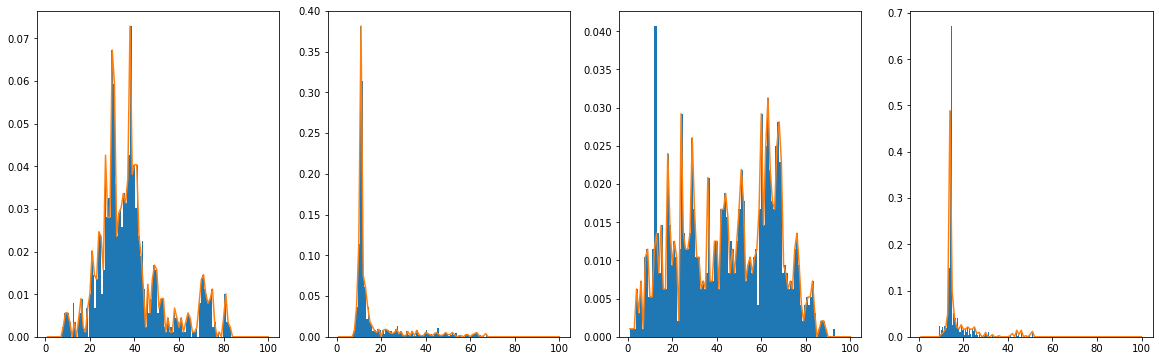

In [104]:
import scipy
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,len(array),figsize=(20,6))
bins = 100

for i in range(len(array)):
    filtered = matid[matid['Final'] == array[i]]
    hist_dist = scipy.stats.rv_histogram(np.histogram(filtered['avg_atomic_num'],bins=bins))
    X = np.linspace(1,100, bins)
    #ax[i].title("PDF of {}" .format(array[i]))
    ax[i].hist(filtered['avg_atomic_num'], density=True, bins=bins)
    ax[i].plot(X, hist_dist.pdf(X), label='PDF')